<a href="https://colab.research.google.com/github/chanchanuu/chanchan-git/blob/master/store%EC%8B%9C%EA%B3%84%EC%97%B4_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
import os

# 로드 데이터

In [ ]:
df_holi = pd.read_csv('/content/drive/MyDrive/alt 캐글 스터디/상점 시계열 EDA/holidays_events.csv')
df_oil = pd.read_csv('/content/drive/MyDrive/alt 캐글 스터디/상점 시계열 EDA/oil.csv')
df_stores = pd.read_csv('/content/drive/MyDrive/alt 캐글 스터디/상점 시계열 EDA/stores.csv')
df_test = pd.read_csv('/content/drive/MyDrive/alt 캐글 스터디/상점 시계열 EDA/test.csv')
df_train = pd.read_csv('/content/drive/MyDrive/alt 캐글 스터디/상점 시계열 EDA/train.csv')
df_transactions = pd.read_csv('/content/drive/MyDrive/alt 캐글 스터디/상점 시계열 EDA/transactions.csv')

### datetime 변경



In [ ]:
def date_form(df):
    df['date'] = pd.to_datetime(df['date'], format = "%Y-%m-%d")
#     df.head()
    

In [ ]:
# Applying data_from function to dataset
date_form(df_holi)
date_form(df_oil)
date_form(df_train)
date_form(df_test)
date_form(df_transactions)

# 전처리

In [ ]:
df_train["family"].nunique(dropna=True)

33

In [ ]:
df_test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [ ]:
# onpromotion 안쓰면 제거

train_data = df_train.copy().drop(['onpromotion'], axis=1)
test_data = df_test.copy().drop(['onpromotion'], axis=1)

#### 스케일링


In [ ]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler

In [ ]:
###one-hot 인코딩
ordinal_encoder = OrdinalEncoder(dtype=int)
train_data[['family']] = ordinal_encoder.fit_transform(train_data[['family']])
test_data[['family']] = ordinal_encoder.transform(test_data[['family']])

In [ ]:
train_data

,id,date,store_nbr,family,sales
0,0,2013-01-01,1,0,0.000
1,1,2013-01-01,1,1,0.000
2,2,2013-01-01,1,2,0.000
3,3,2013-01-01,1,3,0.000
4,4,2013-01-01,1,4,0.000
...,...,...,...,...,...
3000883,3000883,2017-08-15,9,28,438.133
3000884,3000884,2017-08-15,9,29,154.553
3000885,3000885,2017-08-15,9,30,2419.729
3000886,3000886,2017-08-15,9,31,121.000


In [ ]:
n_o_days_train=train_data["date"].nunique(dropna = False) 
print('number of day train:',n_o_days_train)

n_o_stores_train=train_data["store_nbr"].nunique(dropna = False) 
print('number of stores train:',n_o_stores_train)

n_o_families_train=train_data["family"].nunique(dropna = False) 
print('number of family/type of prod train:',n_o_families_train)

number of day train: 1684
number of stores train: 54
number of family/type of prod train: 33


In [ ]:
n_o_days_test=test_data["date"].nunique(dropna = False) 
print('number of day test:',n_o_days_test)

n_o_stores_test=test_data["store_nbr"].nunique(dropna = False) 
print('number of stores test:',n_o_stores_test)

n_o_families_test=test_data["family"].nunique(dropna = False) 
print('number of family/type of prod test:',n_o_families_test)

number of day test: 16
number of stores test: 54
number of family/type of prod test: 33


In [ ]:
pivoted_train = train_data.pivot(index=['date'], columns=['store_nbr', 'family'], values='sales')
pivoted_train.head()

store_nbr     1                                                               \
family       0    1    2       3    4        5    6       7      8        9    
date                                                                           
2013-01-01  0.0  0.0  0.0     0.0  0.0    0.000  0.0     0.0    0.0    0.000   
2013-01-02  2.0  0.0  2.0  1091.0  0.0  470.652  0.0  1060.0  579.0  164.069   
2013-01-03  3.0  0.0  0.0   919.0  0.0  310.655  0.0   836.0  453.0  151.582   
2013-01-04  3.0  0.0  3.0   953.0  0.0  198.366  0.0   827.0  460.0  131.411   
2013-01-05  5.0  0.0  3.0  1160.0  0.0  301.057  0.0   811.0  464.0  118.613   

store_nbr   ...    9                                                     \
family      ...   23       24     25   26   27       28    29   30   31   
date        ...                                                           
2013-01-01  ...  0.0    0.000    0.0  0.0  0.0    0.000   0.0  0.0  0.0   
2013-01-02  ...  0.0  374.531  482.0  0.0  0.0  651.292  83.0  0.0  0.0   
2013-01-03  ...  0.0  400.863  372.0  0.0  0.0  509.496  66.0  0.0  0.0   
2013-01-04  ...  0.0  310.878  324.0  0.0  0.0  332.672  57.0  0.0  0.0   
2013-01-05  ...  0.0  447.685  461.0  0.0  0.0  510.919  84.0  0.0  0.0   

store_nbr           
family          32  
date                
2013-01-01   0.000  
2013-01-02  29.214  
2013-01-03  25.000  
2013-01-04  11.000  
2013-01-05  28.361  

[5 rows x 1782 columns]

In [ ]:
pivoted_train[1][0]

date
2013-01-01    0.0
2013-01-02    2.0
2013-01-03    3.0
2013-01-04    3.0
2013-01-05    5.0
             ... 
2017-08-11    1.0
2017-08-12    6.0
2017-08-13    1.0
2017-08-14    1.0
2017-08-15    4.0
Name: 0, Length: 1684, dtype: float64

## train, validation set 분리

In [ ]:
# 시계열은 shuffle = false
train_samples = int(n_o_days_train*0.95)
train_samples

1599

In [ ]:
train_samples_df = pivoted_train[:train_samples]
train_samples_df

store_nbr     1                                                                \
family       0    1    2       3    4        5     6       7      8        9    
date                                                                            
2013-01-01  0.0  0.0  0.0     0.0  0.0    0.000   0.0     0.0    0.0    0.000   
2013-01-02  2.0  0.0  2.0  1091.0  0.0  470.652   0.0  1060.0  579.0  164.069   
2013-01-03  3.0  0.0  0.0   919.0  0.0  310.655   0.0   836.0  453.0  151.582   
2013-01-04  3.0  0.0  3.0   953.0  0.0  198.366   0.0   827.0  460.0  131.411   
2013-01-05  5.0  0.0  3.0  1160.0  0.0  301.057   0.0   811.0  464.0  118.613   
...         ...  ...  ...     ...  ...      ...   ...     ...    ...      ...   
2017-05-18  4.0  0.0  2.0  2154.0  0.0  350.502  12.0   669.0  718.0  132.686   
2017-05-19  5.0  0.0  4.0  2743.0  0.0  481.324  24.0   826.0  957.0  177.191   
2017-05-20  4.0  0.0  3.0  2379.0  0.0  392.965   7.0   588.0  795.0  140.261   
2017-05-21  1.0  0.0  1.0   974.0  0.0  161.529   1.0   243.0  337.0   75.683   
2017-05-22  2.0  0.0  5.0  2620.0  1.0  418.029  16.0   712.0  754.0  129.027   

store_nbr   ...    9                                                       \
family      ...   23         24     25    26    27         28          29   
date        ...                                                             
2013-01-01  ...  0.0    0.00000    0.0   0.0   0.0    0.00000    0.000000   
2013-01-02  ...  0.0  374.53100  482.0   0.0   0.0  651.29200   83.000000   
2013-01-03  ...  0.0  400.86300  372.0   0.0   0.0  509.49600   66.000000   
2013-01-04  ...  0.0  310.87800  324.0   0.0   0.0  332.67200   57.000000   
2013-01-05  ...  0.0  447.68500  461.0   0.0   0.0  510.91900   84.000000   
...         ...  ...        ...    ...   ...   ...        ...         ...   
2017-05-18  ...  4.0  541.15700  344.0  19.0  12.0  313.56600   73.060000   
2017-05-19  ...  2.0  264.74400  268.0   6.0   8.0  477.29602   79.421000   
2017-05-20  ...  5.0  373.00400  569.0  10.0  12.0  503.79500  151.274000   
2017-05-21  ...  2.0  492.31302  636.0  10.0  18.0  688.77600  149.067000   
2017-05-22  ...  4.0  319.78200  345.0   8.0   9.0  321.63200  111.423004   

store_nbr                              
family             30   31         32  
date                                   
2013-01-01     0.0000  0.0   0.000000  
2013-01-02     0.0000  0.0  29.214000  
2013-01-03     0.0000  0.0  25.000000  
2013-01-04     0.0000  0.0  11.000000  
2013-01-05     0.0000  0.0  28.361000  
...               ...  ...        ...  
2017-05-18  1262.8600  7.0  12.544001  
2017-05-19  1149.9869  2.0   9.238000  
2017-05-20  2008.8520  3.0  27.380001  
2017-05-21  2424.7440  7.0  39.710000  
2017-05-22  1413.0350  2.0  19.097000  

[1599 rows x 1782 columns]

In [ ]:
train_samples_df.

TypeError: ignored

In [ ]:
valid_samples_df = pivoted_train[train_samples:]
valid_samples_df

store_nbr     1                                                        \
family       0    1    2       3    4          5     6      7      8    
date                                                                    
2017-05-23  4.0  0.0  1.0  2365.0  1.0  413.15200   8.0  822.0  736.0   
2017-05-24  7.0  0.0  1.0  2611.0  1.0  349.68100  11.0  944.0  867.0   
2017-05-25  2.0  0.0  1.0  2229.0  0.0  372.38500  18.0  706.0  723.0   
2017-05-26  1.0  0.0  0.0  1100.0  0.0  190.73300   7.0  303.0  375.0   
2017-05-27  1.0  0.0  2.0  2270.0  0.0  300.78600  10.0  462.0  634.0   
...         ...  ...  ...     ...  ...        ...   ...    ...    ...   
2017-08-11  1.0  0.0  1.0  1006.0  0.0  145.60700   4.0  341.0  343.0   
2017-08-12  6.0  0.0  3.0  1659.0  0.0  243.22000   3.0  351.0  526.0   
2017-08-13  1.0  0.0  1.0   803.0  0.0  136.67900   1.0  169.0  266.0   
2017-08-14  1.0  0.0  6.0  2201.0  0.0  346.03800   4.0  571.0  699.0   
2017-08-15  4.0  0.0  4.0  1942.0  0.0  329.54102  21.0  703.0  602.0   

store_nbr            ...     9                                         \
family           9   ...    23       24     25    26    27         28   
date                 ...                                                
2017-05-23  127.909  ...   1.0  284.679  340.0   5.0  12.0  328.32900   
2017-05-24  166.068  ...   1.0  318.254  292.0   6.0  12.0  360.76498   
2017-05-25  122.562  ...   1.0  415.299  260.0   7.0  10.0  261.97600   
2017-05-26   82.697  ...   5.0  378.795  382.0   9.0   9.0  533.20300   
2017-05-27   99.587  ...   3.0  412.021  455.0   8.0  11.0  541.38000   
...             ...  ...   ...      ...    ...   ...   ...        ...   
2017-08-11   64.302  ...   5.0  309.245  373.0  11.0   2.0  525.22400   
2017-08-12   99.488  ...   2.0  260.298  400.0   7.0  10.0  383.38700   
2017-08-13   47.770  ...   3.0  327.206  510.0   2.0   9.0  412.45800   
2017-08-14  154.578  ...  12.0  330.975  445.0   2.0  14.0  283.42900   
2017-08-15  116.402  ...  11.0  449.228  522.0   6.0   6.0  438.13300   

store_nbr                                           
family             29         30     31         32  
date                                                
2017-05-23  127.40600  2268.3320    1.0  16.063000  
2017-05-24  104.61800  1180.0780    2.0  18.163000  
2017-05-25  110.95700   920.1430    5.0   2.994000  
2017-05-26  169.91900  1515.1750   13.0  20.683000  
2017-05-27  134.74800  1634.6849    5.0  43.512000  
...               ...        ...    ...        ...  
2017-08-11  112.10000  1453.0780  140.0  23.831000  
2017-08-12  129.90399  1419.2640  138.0  16.859001  
2017-08-13  105.16900  1693.6070  200.0  20.000000  
2017-08-14  114.12000  1348.4250  182.0  17.000000  
2017-08-15  154.55300  2419.7290  121.0  16.000000  

[85 rows x 1782 columns]



### 스케일링

In [ ]:
minmax = MinMaxScaler()
minmax.fit(train_samples_df)

scaled_train_samples = minmax.transform(train_samples_df)
scaled_val_samples = minmax.transform(valid_samples_df)

In [ ]:
scaled_train_samples[10:]

array([[0.16666667, 0.        , 0.16666667, ..., 0.        , 0.        ,
        0.1939255 ],
       [0.11111111, 0.        , 0.        , ..., 0.        , 0.        ,
        0.32272206],
       [0.11111111, 0.        , 0.        , ..., 0.        , 0.        ,
        0.24110331],
       ...,
       [0.22222222, 0.        , 0.25      , ..., 0.49480247, 0.00920245,
        0.45467379],
       [0.05555556, 0.        , 0.08333333, ..., 0.59724127, 0.02147239,
        0.65942643],
       [0.11111111, 0.        , 0.41666667, ..., 0.34804615, 0.00613497,
        0.31712582]])

In [ ]:
scaled_val_samples[10:]


array([[1.05555556, 0.        , 0.08333333, ..., 0.35775819, 0.01840491,
        0.1826666 ],
       [0.44444444, 0.        , 0.08333333, ..., 0.49624388, 0.01533742,
        0.48497982],
       [0.        , 0.        , 0.16666667, ..., 0.62189011, 0.05214724,
        0.78270978],
       ...,
       [0.05555556, 0.        , 0.08333333, ..., 0.41715414, 0.61349693,
        0.33212109],
       [0.05555556, 0.        , 0.5       , ..., 0.33213199, 0.55828221,
        0.28230293],
       [0.22222222, 0.        , 0.33333333, ..., 0.59600602, 0.37116564,
        0.26569687]])

In [ ]:
def split_series(series, n_past, n_future):
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
            
        
        past, future = series[window_start:past_end,:], series[past_end:future_end,:]
        X.append(past)
        y.append(future)
    
    return np.array(X), np.array(y)

n_past = 16
n_future = 16
n_features = n_o_stores_train * n_o_families_train # 칼럼 개수, 예측해야하는 데이터 수(마지막 dense)

In [ ]:
n_features

1782

In [ ]:
X_train, y_train = split_series(scaled_train_samples, n_past, n_future)
X_val, y_val = split_series(scaled_val_samples, n_past, n_future)

In [ ]:
print('X_train.shape',X_train.shape)
print('y_train.shape',y_train.shape)
print('X_val.shape',X_val.shape)
print('y_val.shape',y_val.shape)

X_train.shape (1568, 16, 1782)
y_train.shape (1568, 16, 1782)
X_val.shape (54, 16, 1782)
y_val.shape (54, 16, 1782)


In [ ]:
X_train

# 모델링(LSTM)

In [ ]:
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.layers import Dropout, BatchNormalization, TimeDistributed
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
model = Sequential()

model.add(LSTM(units=256, return_sequences=True,input_shape=[n_past, n_features]))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(LSTM(units=128, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(LSTM(units=32, return_sequences=True))
#TimeDistributed layer
model.add(TimeDistributed(Dense(n_features)))

model.compile(loss="mae", optimizer=Adam(learning_rate=0.01), metrics=['mae'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16, 256)           2087936   
                                                                 
 batch_normalization (BatchN  (None, 16, 256)          1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 16, 256)           0         
                                                                 
 lstm_1 (LSTM)               (None, 16, 128)           197120    
                                                                 
 batch_normalization_1 (Batc  (None, 16, 128)          512       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 16, 128)           0

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_mae', 
                           min_delta=0.0001,
                           patience=100,
                           restore_best_weights=True)

epochs= 100

model_history = model.fit(X_train, y_train, 
                          validation_data=(X_val, y_val),
                          epochs = epochs,
                          callbacks = [early_stop],
                          batch_size=512,
                          shuffle=True)

Epoch 1/100
4/4 [==============================] - 14s 2s/step - loss: 0.1756 - mae: 0.1756 - val_loss: 0.1519 - val_mae: 0.1519
Epoch 2/100
4/4 [==============================] - 6s 1s/step - loss: 0.0941 - mae: 0.0941 - val_loss: 0.1268 - val_mae: 0.1268
Epoch 3/100
4/4 [==============================] - 6s 1s/step - loss: 0.0750 - mae: 0.0750 - val_loss: 0.1283 - val_mae: 0.1283
Epoch 4/100
4/4 [==============================] - 6s 1s/step - loss: 0.0695 - mae: 0.0695 - val_loss: 0.1103 - val_mae: 0.1103
Epoch 5/100
4/4 [==============================] - 10s 3s/step - loss: 0.0662 - mae: 0.0662 - val_loss: 0.0991 - val_mae: 0.0991
Epoch 6/100
4/4 [==============================] - 6s 1s/step - loss: 0.0638 - mae: 0.0638 - val_loss: 0.0942 - val_mae: 0.0942
Epoch 7/100
4/4 [==============================] - 6s 1s/step - loss: 0.0618 - mae: 0.0618 - val_loss: 0.0941 - val_mae: 0.0941
Epoch 8/100
4/4 [==============================] - 6s 1s/step - loss: 0.0599 - mae: 0.0599 - val_loss:

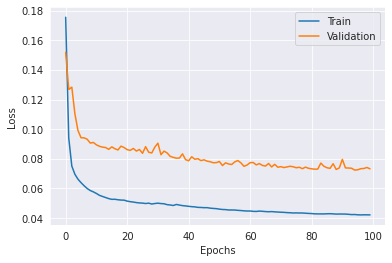

In [ ]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_mae'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Train', 'Validation'])
plt.show()

# 결과 확인, 예측

In [ ]:
X_test_pred = scaled_val_samples[-n_past:,:].reshape((1, n_past, n_features))
print(X_test_pred.shape)
scaled_test_predict = model.predict(X_test_pred)

(1, 16, 1782)


In [ ]:
scaled_test_predict.shape

(1, 16, 1782)

In [ ]:
X_train_pred = scaled_train_samples[-n_past:,:].reshape((1, n_past, n_features))
print(X_train_pred.shape)
scaled_train_predict = model.predict(X_test_pred)

(1, 16, 1782)


In [ ]:
scaled_train_predict.shape

(1, 16, 1782)

In [ ]:
# Inverse transform from the previous min max scaler
y_predict = pd.DataFrame(minmax.inverse_transform(scaled_test_predict.reshape((n_future, n_features))),columns=valid_samples_df.columns)

In [ ]:
y_predict

store_nbr         1                                                         \
family           0         1         2            3         4           5    
0          3.488348  0.001453  2.881411  2408.522217  0.072997  447.958099   
1          3.531698  0.001653  3.081108  2203.313232  0.055961  410.433990   
2          3.869896  0.000838  3.285960  2562.882324  0.075755  453.122009   
3          3.667929  0.003292  3.075615  2480.854736  0.080648  407.380310   
4          0.683458  0.005798  1.378750  1225.082886  0.091364  167.823608   
5          3.460370  0.002171  3.449136  2599.256348  0.083710  470.351532   
6          3.384915  0.001960  3.136133  2313.007812  0.061959  423.022644   
7          3.438122  0.001984  3.304167  2567.927246  0.070974  486.841583   
8          3.541441  0.001586  3.062531  2137.149170  0.047509  404.533875   
9          3.971564  0.000593  3.115952  2498.260986  0.070014  437.904541   
10         3.820952  0.002903  3.184838  2437.449951  0.068631  407.809692   
11         1.629045  0.004405  1.701615  1460.468384  0.067249  228.380035   
12         3.421169  0.002126  3.050885  2342.348389  0.058229  434.386719   
13         3.579692  0.001874  2.907473  2196.539795  0.040634  414.143524   
14         3.720452  0.001927  3.070320  2479.061523  0.047223  479.714569   
15         3.920681  0.001797  3.000424  2161.773193  0.034730  417.141022   

store_nbr                                                 ...         9  \
family            6           7           8           9   ...        23   
0          18.203756  815.712097  893.488831  149.819717  ...  2.530774   
1          20.673033  717.647217  762.335510  139.215973  ...  2.235692   
2          24.541624  815.530823  882.791992  178.100861  ...  2.654988   
3          17.532200  632.742371  841.018311  145.654221  ...  4.565160   
4           8.107959  264.033875  403.364990   66.366035  ...  5.409890   
5          18.583990  782.569519  893.742188  168.043182  ...  2.636589   
6          19.911621  735.460144  788.884094  145.968933  ...  2.210970   
7          20.985096  850.089539  937.833374  154.762573  ...  2.355705   
8          21.724121  709.708008  742.272339  135.064987  ...  2.108696   
9          25.135910  797.285461  858.133484  177.179321  ...  2.685387   
10         18.441429  639.042114  843.245544  146.412964  ...  4.091331   
11         10.828942  367.951294  502.550812   86.505447  ...  4.401114   
12         17.869932  721.989563  813.127930  153.091721  ...  2.369339   
13         20.191395  720.645569  760.857971  141.894562  ...  1.928103   
14         21.542036  846.418396  918.273010  155.430252  ...  2.020622   
15         21.676952  719.034973  768.673035  140.763809  ...  2.113055   

store_nbr                                                            \
family             24          25         26         27          28   
0          310.730743  351.948822   5.151792   9.292853  371.085907   
1          412.223145  357.776398   4.516584   9.622125  352.347534   
2          279.123352  286.299652   4.757613   9.556384  353.786133   
3          407.690735  537.435974   8.026776  15.726908  502.429871   
4          473.107117  647.278687  10.256982  19.333559  632.791565   
5          365.760986  418.361877   5.628848  11.254581  387.201416   
6          411.724304  399.881470   5.000438  10.625483  363.415497   
7          338.061768  335.053497   5.248949   9.632097  302.563629   
8          417.884369  325.621124   4.075676   8.952760  331.080200   
9          275.666748  282.719391   4.540128   9.258508  371.487274   
10         391.891418  480.667603   6.975583  14.278828  485.605865   
11         428.026123  553.878601   8.067253  16.382656  565.070251   
12         359.690643  393.701660   4.714250  10.313280  377.339355   
13         397.150604  374.292053   3.900240   9.479434  362.225281   
14         325.280609  338.819122   4.061145   8.908025  325.459808   
15         405.343781  356.278839   3

In [ ]:
pivoted_test = test_data.pivot(index=['date'], columns=['store_nbr', 'family'], values=None)
pivoted_test

id                                                        \
store_nbr         1                                                         
family           0        1        2        3        4        5        6    
date                                                                        
2017-08-16  3000888  3000889  3000890  3000891  3000892  3000893  3000894   
2017-08-17  3002670  3002671  3002672  3002673  3002674  3002675  3002676   
2017-08-18  3004452  3004453  3004454  3004455  3004456  3004457  3004458   
2017-08-19  3006234  3006235  3006236  3006237  3006238  3006239  3006240   
2017-08-20  3008016  3008017  3008018  3008019  3008020  3008021  3008022   
2017-08-21  3009798  3009799  3009800  3009801  3009802  3009803  3009804   
2017-08-22  3011580  3011581  3011582  3011583  3011584  3011585  3011586   
2017-08-23  3013362  3013363  3013364  3013365  3013366  3013367  3013368   
2017-08-24  3015144  3015145  3015146  3015147  3015148  3015149  3015150   
2017-08-25  3016926  3016927  3016928  3016929  3016930  3016931  3016932   
2017-08-26  3018708  3018709  3018710  3018711  3018712  3018713  3018714   
2017-08-27  3020490  3020491  3020492  3020493  3020494  3020495  3020496   
2017-08-28  3022272  3022273  3022274  3022275  3022276  3022277  3022278   
2017-08-29  3024054  3024055  3024056  3024057  3024058  3024059  3024060   
2017-08-30  3025836  3025837  3025838  3025839  3025840  3025841  3025842   
2017-08-31  3027618  3027619  3027620  3027621  3027622  3027623  3027624   

                                       ...                             \
store_nbr                              ...        9                     
family           7        8        9   ...       23       24       25   
date                                   ...                              
2017-08-16  3000895  3000896  3000897  ...  3002660  3002661  3002662   
2017-08-17  3002677  3002678  3002679  ...  3004442  3004443  3004444   
2017-08-18  3004459  3004460  3004461  ...  3006224  3006225  3006226   
2017-08-19  3006241  3006242  3006243  ...  3008006  3008007  3008008   
2017-08-20  3008023  3008024  3008025  ...  3009788  3009789  3009790   
2017-08-21  3009805  3009806  3009807  ...  3011570  3011571  3011572   
2017-08-22  3011587  3011588  3011589  ...  3013352  3013353  3013354   
2017-08-23  3013369  3013370  3013371  ...  3015134  3015135  3015136   
2017-08-24  3015151  3015152  3015153  ...  3016916  3016917  3016918   
2017-08-25  3016933  3016934  3016935  ...  3018698  3018699  3018700   
2017-08-26  3018715  3018716  3018717  ...  3020480  3020481  3020482   
2017-08-27  3020497  3020498  3020499  ...  3022262  3022263  3022264   
2017-08-28  3022279  3022280  3022281  ...  3024044  3024045  3024046   
2017-08-29  3024061  3024062  3024063  ...  3025826  3025827  3025828   
2017-08-30  3025843  3025844  3025845  ...  3027608  3027609  3027610   
2017-08-31  3027625  3027626  3027627  ...  3029390  3029391  3029392   

                                                                           
store_nbr                                                                  
family           26       27       28       29       30       31       32  
date                                                                       
2017-08-16  3002663  3002664  3002665  3002666  3002667  3002668  3002669  
2017-08-17  3004445  3004446  3004447  3004448  3004449  3004450  3004451  
2017-08-18  3006227  3006228  3006229  3006230  3006231  3006232  3006233  
2017-08-19  3008009  3008010  3008011  3008012  3008013  3008014  3008015  
2017-08-20  3009791  3009792  3009793  3009794  3009795  3009796  3009797  
2017-08-21  3011573  3011574  3011575  3011576  3011577  3011578  3011579  
2017-08-22  3013355  3013356  3013357  3013358  3013359  3013360  3013361  
2017-08-23  3015137  3015138  3015139  3015140  3015141  3015142  3015143  
2017-08-24  3016919  3016920  3016921  3016922  3016923  3016924  3016925  
2017-08-25  3018701  301870

In [ ]:
pivoted_test.values

array([[3000888, 3000889, 3000890, ..., 3002667, 3002668, 3002669],
       [3002670, 3002671, 3002672, ..., 3004449, 3004450, 3004451],
       [3004452, 3004453, 3004454, ..., 3006231, 3006232, 3006233],
       ...,
       [3024054, 3024055, 3024056, ..., 3025833, 3025834, 3025835],
       [3025836, 3025837, 3025838, ..., 3027615, 3027616, 3027617],
       [3027618, 3027619, 3027620, ..., 3029397, 3029398, 3029399]])

In [ ]:
pivoted_train.values

array([[0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [2.000000e+00, 0.000000e+00, 2.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 2.921400e+01],
       [3.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 2.500000e+01],
       ...,
       [1.000000e+00, 0.000000e+00, 1.000000e+00, ..., 1.693607e+03,
        2.000000e+02, 2.000000e+01],
       [1.000000e+00, 0.000000e+00, 6.000000e+00, ..., 1.348425e+03,
        1.820000e+02, 1.700000e+01],
       [4.000000e+00, 0.000000e+00, 4.000000e+00, ..., 2.419729e+03,
        1.210000e+02, 1.600000e+01]])

# 제출

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/alt 캐글 스터디/상점 시계열 EDA/sample_submission.csv')

In [ ]:
submission

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0
...,...,...
28507,3029395,0.0
28508,3029396,0.0
28509,3029397,0.0
28510,3029398,0.0


In [ ]:
## mapping ypredict to pivoted test data
for day_ith, day_ith_pred in y_predict.iterrows():
    #day_ith iteration, 16 days in totals
    #day_ith_pred, predicted data of 9 stores, 33 classes of good for each day
    #Iterate over DataFrame rows as (index, Series) pairs.
#     print(n_samples_per_day)
    # n_samples_per_day number of 
    for n_samples_per_day in range(len(day_ith_pred)): ## iterating the number of sample, from 0 to 1781, for 16 days
#         print(pivoted_test.iloc[[day_ith], [n_samples_per_day]])
        sample_id = pivoted_test.iloc[[day_ith], [n_samples_per_day]].values[0][0] #total number of samples
        values= max(0,day_ith_pred.values[n_samples_per_day]) #price that is negative will be set to 0
        submission.at[sample_id, 'sales'] = values

In [ ]:
submission

,id,sales
0,3000888.0,0.000000
1,3000889.0,0.000000
2,3000890.0,0.000000
3,3000891.0,0.000000
4,3000892.0,0.000000
...,...,...
3029395,NaN,366.666748
3029396,NaN,91.972801
3029397,NaN,1269.437256
3029398,NaN,2.162226


In [ ]:
sub = pd.DataFrame(submission.sales[28512:])

In [ ]:
sub['id'] = sub.index

In [ ]:
sub.columns = ['id','sales']

In [ ]:
sub = sub[['id','sales']]


In [ ]:
sub = sub.reset_index(drop=True)

In [ ]:
sub

,id,sales
0,3000888,3.488348
1,3000889,0.001453
2,3000890,2.881411
3,3000891,2408.522217
4,3000892,0.072997
...,...,...
28507,3029395,366.666748
28508,3029396,91.972801
28509,3029397,1269.437256
28510,3029398,2.162226


In [ ]:
sub.to_csv('/content/drive/MyDrive/alt 캐글 스터디/상점 시계열 EDA/store_submission.csv', index = False)

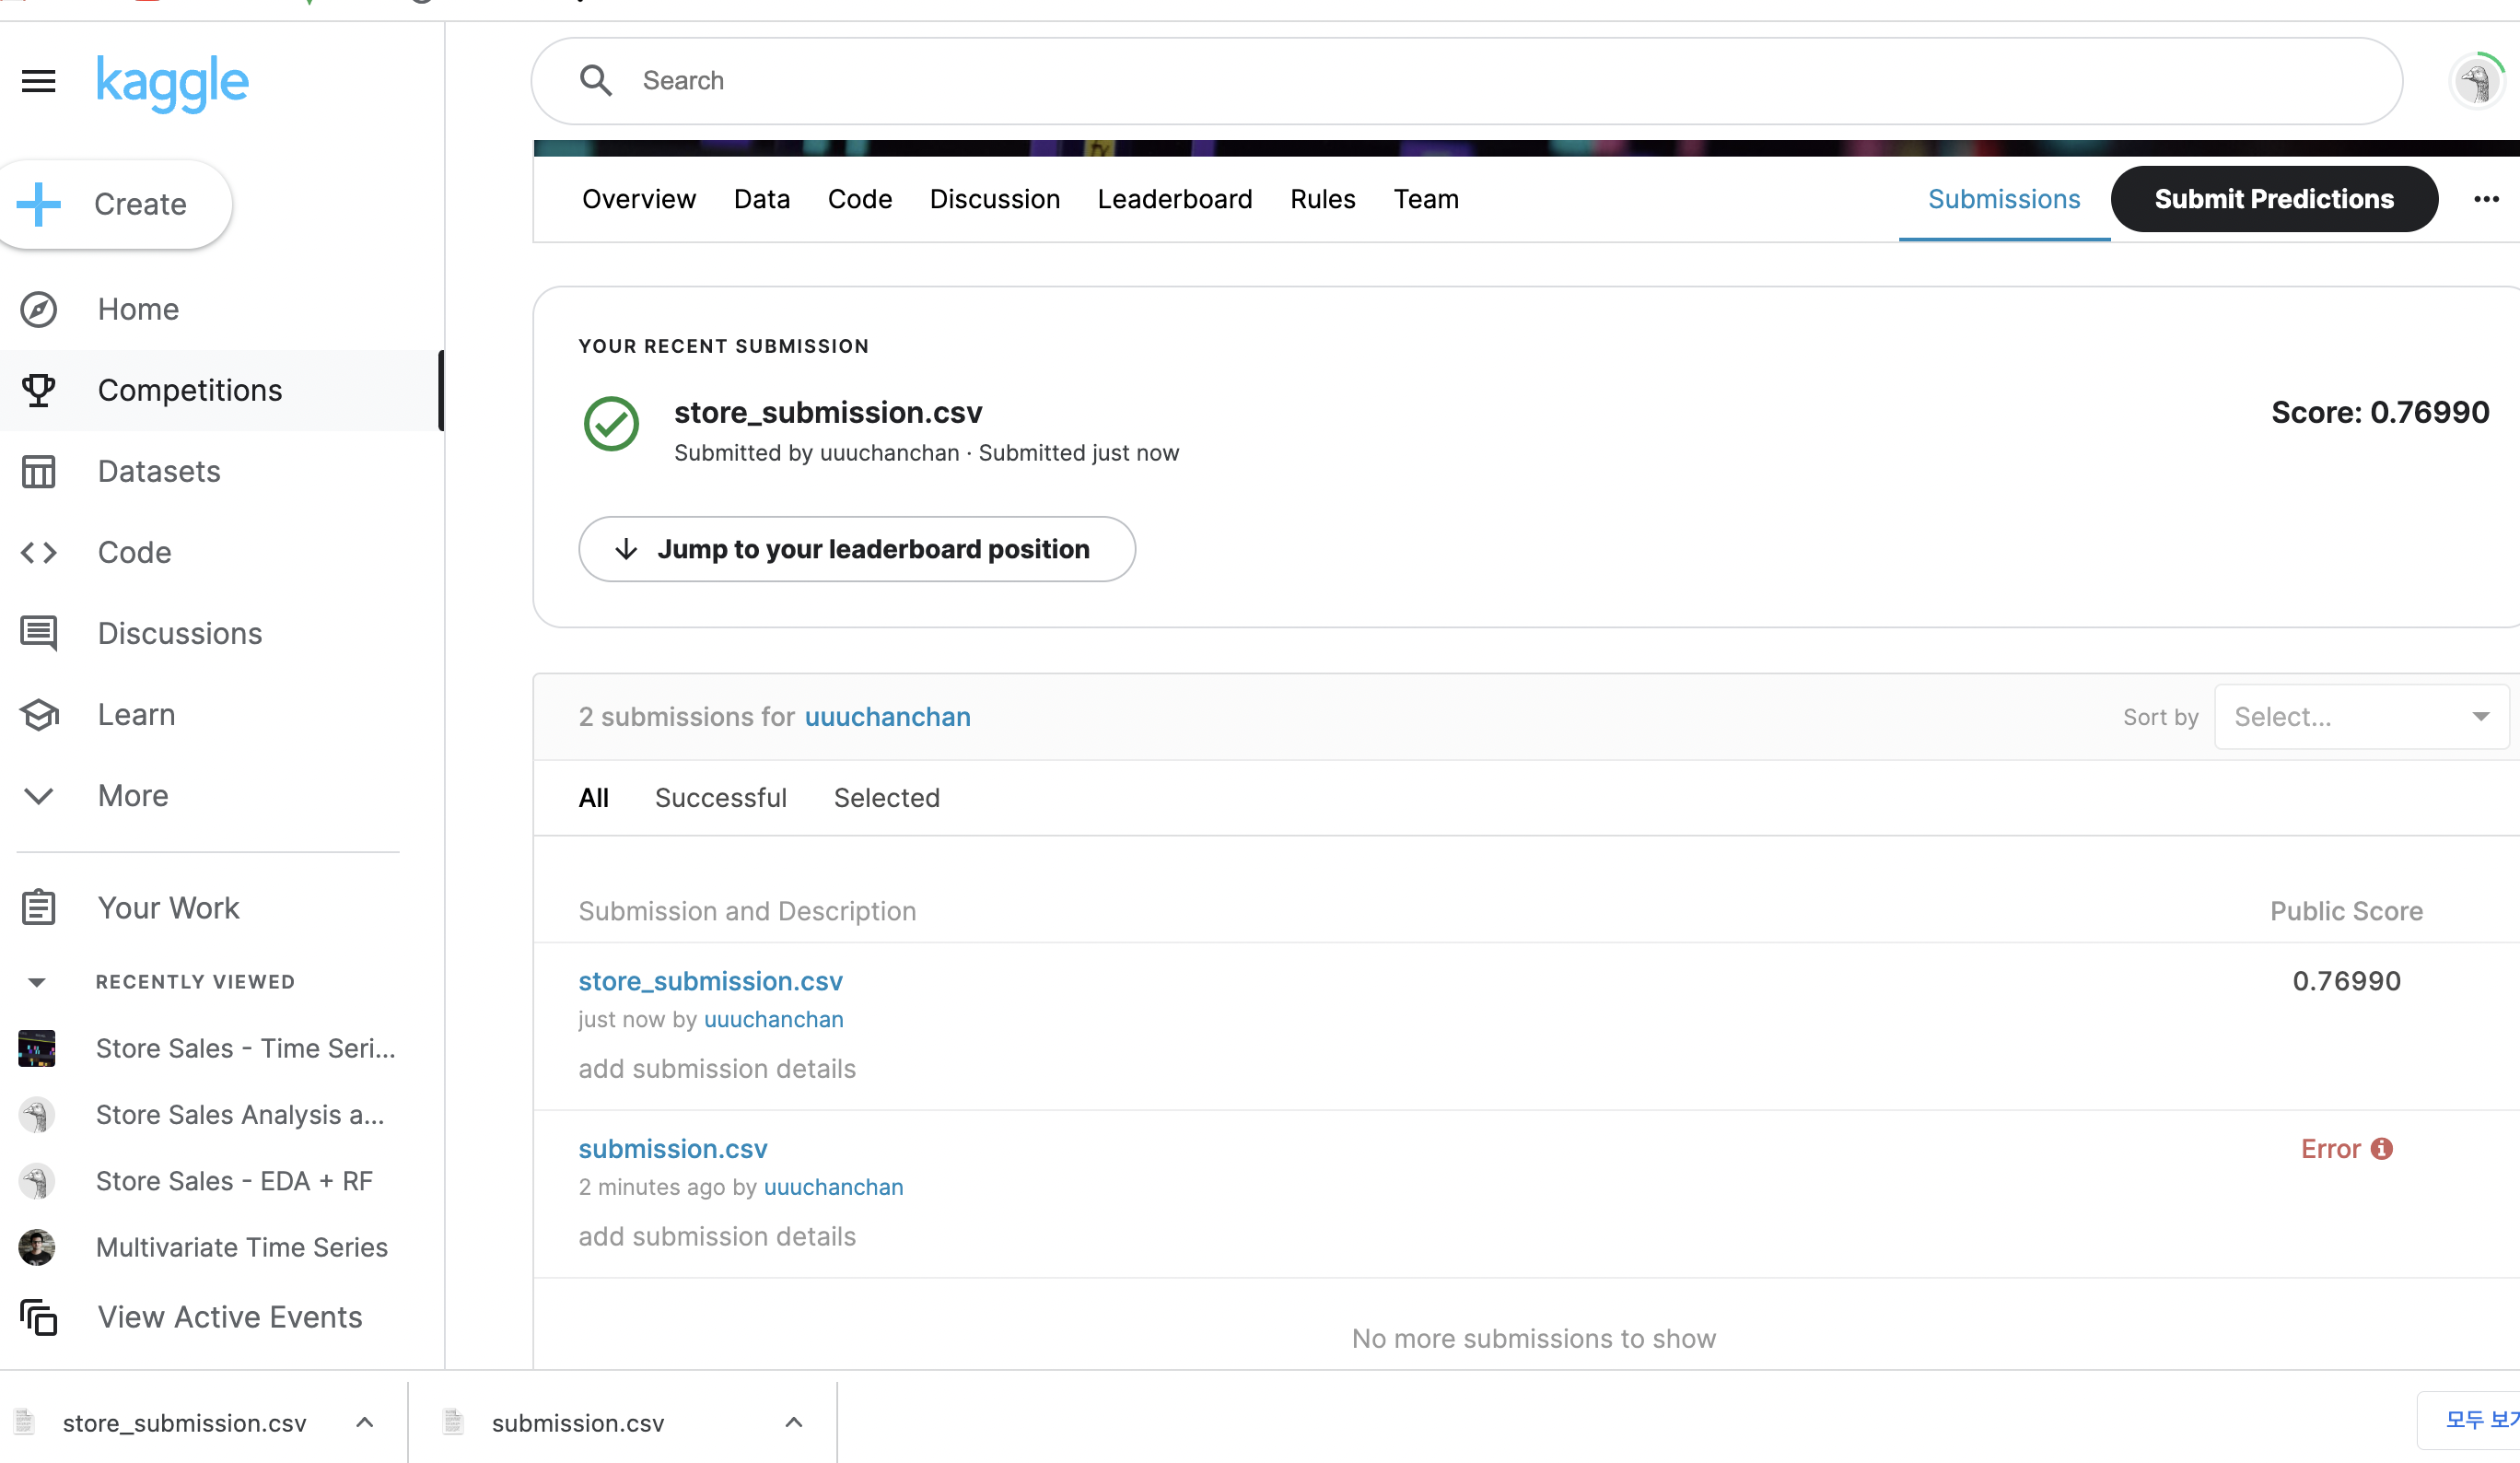

## Thank You!